In [1]:
import keras
%matplotlib inline
import matplotlib.pyplot as plt





Using TensorFlow backend.
C:\Users\GSD\Anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\GSD\Anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\GSD\Anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\GSD\Anaconda3\env

In [2]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np


In [8]:

print(tf.__version__)
print(keras.__version__)


1.13.2
2.3.1


In [10]:
from keras.datasets import cifar10

In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 636s 4us/step


In [13]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [14]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

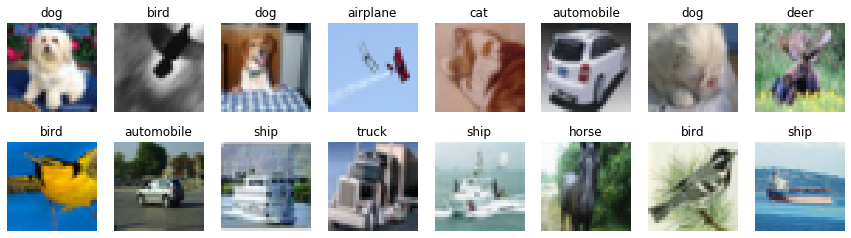

In [46]:
import matplotlib.pyplot as plt
cols = 8

rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

In [18]:
# normalize inputs
x_train2 = x_train/255 -0.5
x_test2 = x_test/255 -0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train,10)
y_test2 =  keras.utils.to_categorical(y_test,10)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [20]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(16,[3,3],padding='same',input_shape=(32,32,3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32,[3,3],padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D([2,2]))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32,[3,3],padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64,[3,3],padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D([2,2]))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.5))
    model.add(LeakyReLU(0.1))
    
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    
    
    
    return model

In [22]:
 # clear default graph
model = make_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
________________________________________________

In [25]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [26]:
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None

In [28]:
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory()],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Instructions for updating:
Use tf.cast instead.
Learning rate: 0.005
Learning rate: 0.0045
Learning rate: 0.00405
Learning rate: 0.003645
Learning rate: 0.0032805
Learning rate: 0.00295245
Learning rate: 0.002657205
Learning rate: 0.0023914846
Learning rate: 0.002152336
Learning rate: 0.0019371024


In [29]:
model.save_weights("weights.h5")

In [30]:
model.load_weights("weights.h5")

In [31]:
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

In [48]:
y_pred_test

array([[2.7017633e-05, 1.5458761e-06, 2.7606528e-05, ..., 1.3003890e-05,
        2.0242655e-03, 1.3850875e-05],
       [4.0404066e-05, 1.1339239e-01, 5.2314490e-12, ..., 2.8068487e-13,
        8.8653821e-01, 2.9013390e-05],
       [4.1550349e-02, 2.6231563e-02, 2.9992098e-06, ..., 2.0745520e-06,
        9.3060714e-01, 1.4358078e-03],
       ...,
       [1.1671200e-06, 3.5886845e-09, 2.2569355e-03, ..., 8.5108494e-03,
        4.3431908e-07, 2.2357257e-07],
       [3.8200151e-03, 9.9602747e-01, 2.1804817e-06, ..., 4.8228856e-07,
        2.2164008e-05, 7.0257949e-05],
       [2.3393809e-12, 1.0775620e-13, 2.3270937e-08, ..., 9.9872357e-01,
        2.7988654e-14, 2.4140721e-13]], dtype=float32)

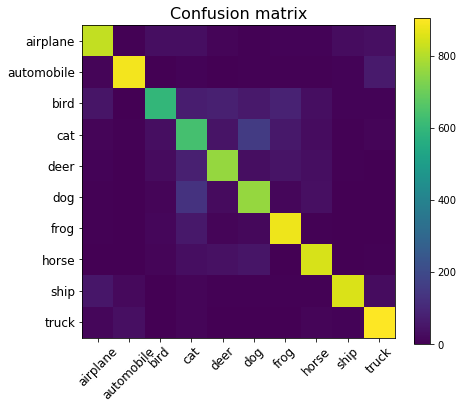

Test accuracy: 0.7953


In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

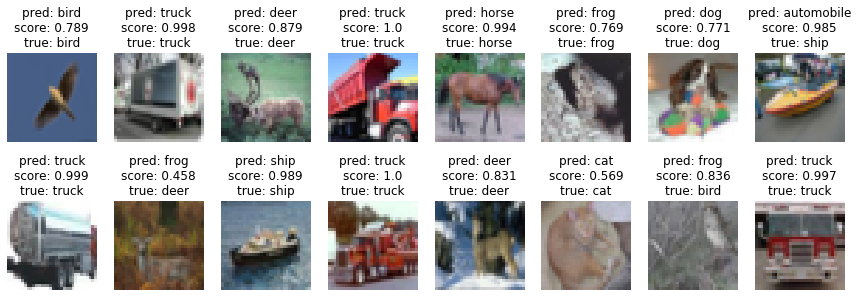

In [33]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)       

In [35]:
from keras import backend as K

In [37]:
K.set_learning_phase(0)

In [38]:
model = make_model()
model.load_weights("weights.h5") 

In [40]:
def find_maximum_stimuli(layer_name, is_conv, filter_index, model, iterations=20, step=1., verbose=True):
    
    def image_values_to_rgb(x):
        # normalize x: center on 0 (np.mean(x_train2)), ensure std is 0.25 (np.std(x_train2))
        # so that it looks like a normalized image input for our network
        x = (x-np.mean(x))/np.square(np.std(x))*0.05 ### YOUR CODE HERE

        # do reverse normalization to RGB values: x = (x_norm + 0.5) * 255
        x =(x+0.5)*255 ### YOUR CODE HERE
    
        # clip values to [0, 255] and convert to bytes
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    # this is the placeholder for the input image
    input_img = model.input
    img_width, img_height = input_img.shape.as_list()[1:3]
    
    # find the layer output by name
    layer_output = list(filter(lambda x: x.name == layer_name, model.layers))[0].output

    # we build a loss function that maximizes the activation
    # of the filter_index filter of the layer considered
    if is_conv:
        # mean over feature map values for convolutional layer
        loss = K.mean(layer_output[:, :, :, filter_index])
    else:
        loss = K.mean(layer_output[:, filter_index])

    # we compute the gradient of the loss wrt input image
    grads = K.gradients(loss, input_img)[0]  # [0] because of the batch dimension!

    # normalization trick: we normalize the gradient
    grads = grads / (K.sqrt(K.sum(K.square(grads))) + 1e-10)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * (0.1 if is_conv else 0.001)

    # we run gradient ascent
    for i in range(iterations):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if verbose:
            print('Current loss value:', loss_value)

    # decode the resulting input image
    img = image_values_to_rgb(input_img_data[0])
    
    return img, loss_value

In [41]:
def plot_filters_stimuli(layer_name, is_conv, model, iterations=20, step=1., verbose=False):
    cols = 8
    rows = 2
    filter_index = 0
    max_filter_index = list(filter(lambda x: x.name == layer_name, model.layers))[0].output.shape.as_list()[-1] - 1
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid('off')
                ax.axis('off')
                loss = -1e20
                while loss < 0 and filter_index <= max_filter_index:
                    stimuli, loss = find_maximum_stimuli(layer_name, is_conv, filter_index, model,
                                                         iterations, step, verbose=verbose)
                    filter_index += 1
                if loss > 0:
                    ax.imshow(stimuli)
                    ax.set_title("Filter #{}".format(filter_index))
    plt.show()

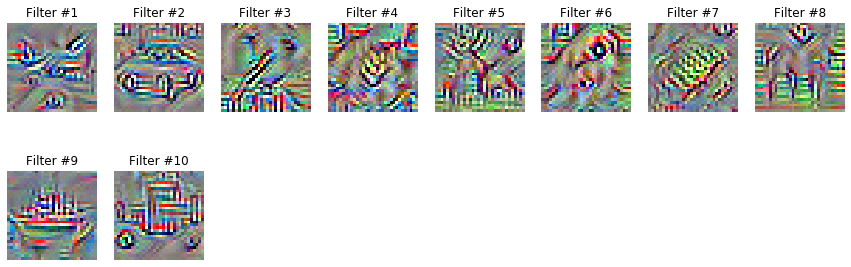

In [43]:
last_dense_layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
plot_filters_stimuli(layer_name=last_dense_layer.name, is_conv=False, 
                     iterations=200, step=0.1, model=model)